## Setup

We're aiming to see what this image looks like:

![](https://pbs.twimg.com/media/GSOpVu7WcAAiaRf?format=png&name=small)

...using UK data.

There are four datasources used:

* [Valuation Office Agency floor space data](https://www.ons.gov.uk/peoplepopulationandcommunity/housing/methodologies/adminbasedstatisticsforpropertyfloorspacefeasibilityresearchenglandandwales#geographical-analysis-of-median-floor-space), which gives us the average square metre per local authority
* [Census 2011 data](https://infuse2011.ukdataservice.ac.uk), which gives us the population-level household data per local authority (as of 2011, but close enough)
* [Median house prices for administrative geographies](https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/medianhousepricesforadministrativegeographies) data from the ONS, which is I believe an aggregate from the Land Registry's Price Paid dataset
* [House building, UK: permanent dwellings started and completed by local authority](https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/housebuildingukpermanentdwellingsstartedandcompletedbylocalauthority), also from the ONS

This is, as should be clear, an inexact piece of science.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [100]:
raw_completions_df = pd.read_csv('data/completions.csv')
raw_prices_df = pd.read_csv('data/median_price_paid.csv')
raw_floorspace_df = pd.read_csv('data/property_floorspace.csv')
raw_population_df = pd.read_csv('data/population.csv')

In [180]:
REGION_NAME = 'region'
AUTHORITY_KEY = 'local_authority'
AUTHORITY_NAME = 'local_authority_name'

## Population

Our x-axis is going to be units built during our timeframe – which is 2009-2023 – per 1,000 units at the beginning of that timeframe.

We have household per local authority counts from the census data.

In [181]:
trimmed_population_df = raw_population_df.drop(['CDU_ID', 'GEO_TYPE','GEO_TYP2', 'Unnamed: 6'], axis=1)
trimmed_population_df['households_in_2011'] = pd.to_numeric(trimmed_population_df['F2410'], errors='coerce')

population_df = trimmed_population_df[['GEO_CODE', 'households_in_2011']].rename(columns={'GEO_CODE': AUTHORITY_KEY})

## Completions

Next up is housing completions. A few preprocessing todos:

* Drop Scotland/Wales/NI, since we're only looking at England.
* Make everything numeric numeric
* interpolate any `NaN` values using linear interpolation (fingers crossed it sort of averages out?)

In [182]:
trimmed_completions_df = raw_completions_df.drop(['Unnamed: 17'], axis=1)
processed_completions_df = trimmed_completions_df.copy().rename(columns={
    'Region or Country Name': REGION_NAME,
    'Local Authority Code': AUTHORITY_KEY,
    'Local Authority Name': AUTHORITY_NAME,
})

textual_columns = [REGION_NAME, AUTHORITY_KEY, AUTHORITY_NAME]

for c in processed_completions_df.columns:
  if c not in textual_columns:
    processed_completions_df[c] = pd.to_numeric(processed_completions_df[c], errors='coerce', downcast='integer')

filtered_completions_df = processed_completions_df[processed_completions_df[AUTHORITY_KEY].str.startswith('E')]

interpolated_completions_df = filtered_completions_df.interpolate()
completions_df = interpolated_completions_df

## Prices

Then house prices:

* Remove non-England rows
* Remove dates before 2009
* Strip tabs from values and make numeric
* Tidy up columns

Once pre-processed, we'll get the median value.

In [183]:
english_prices_df = raw_prices_df[raw_prices_df['Region/Country code'].str.startswith('E')]

columns_to_drop = ['Region/Country code', 'Region/Country name', 'Local authority name', 'Year ending Dec 1995']
for year in range(1996, 2009):
    for month in ['Mar', 'Jun', 'Sep', 'Dec']:
        columns_to_drop.append(f'Year ending {month} {year}')

prices_after_2008_df = english_prices_df.drop(columns_to_drop, axis=1).rename(columns={'Local authority code ': AUTHORITY_KEY})

processed_prices_after_2008_df = prices_after_2008_df.copy()
for c in prices_after_2008_df.columns:
  if c != AUTHORITY_KEY:
    processed_prices_after_2008_df[c] = pd.to_numeric(raw_prices_df[c].apply(lambda x: x.strip().replace(',', '')), errors='coerce')

In [184]:
processed_prices_after_2008_with_median_df = processed_prices_after_2008_df.copy()

data_columns = [col for col in processed_prices_after_2008_df.columns if col.startswith('Year ending')]
processed_prices_after_2008_with_median_df['median'] = processed_prices_after_2008_with_median_df[data_columns].median(axis=1)

prices_df = processed_prices_after_2008_with_median_df[[AUTHORITY_KEY, 'median']]

## Floorspace

And finally get the floorspace. Nice and easy.

In [185]:
floorspace_df = raw_floorspace_df[['AREACD', 'All']].rename(columns={'AREACD': AUTHORITY_KEY, 'All': 'sqm'})

## Assembly

Next up, we merge the completions data with the prices data to get per-local authority data on annual completions and the median price during that period.

We can divide the median price by the sqm to get price per sqm.

We then merge again to get the same with floorspace and number of households.

In [186]:
completions_with_median_df = completions_df.merge(prices_df, on=AUTHORITY_KEY)
completions_with_median_and_floorspace_df = completions_with_median_df.merge(floorspace_df, on=AUTHORITY_KEY)

completions_with_price_per_sqm_df = completions_with_median_and_floorspace_df.copy()
completions_with_price_per_sqm_df['median_price_per_sqm'] = completions_with_price_per_sqm_df['median'] / completions_with_price_per_sqm_df['sqm']

completions_with_price_per_sqm_and_households_df = completions_with_price_per_sqm_df.merge(population_df, on=AUTHORITY_KEY)

Then get the completions per 1,000 households in 2011 by summing the year columns and dividing by the population data

In [191]:
completions_per_1000_households_df = completions_with_price_per_sqm_and_households_df.copy()

data_columns = [col for col in completions_per_1000_households_df.columns if col.startswith('20')]
completions_per_1000_households_df['completions_per_1000_households'] = completions_per_1000_households_df[data_columns].sum(axis=1) / completions_per_1000_households_df['households_in_2011'] * 1000

processed_df = completions_per_1000_households_df[[REGION_NAME, AUTHORITY_KEY, AUTHORITY_NAME, 'median_price_per_sqm', 'completions_per_1000_households']]


## Results

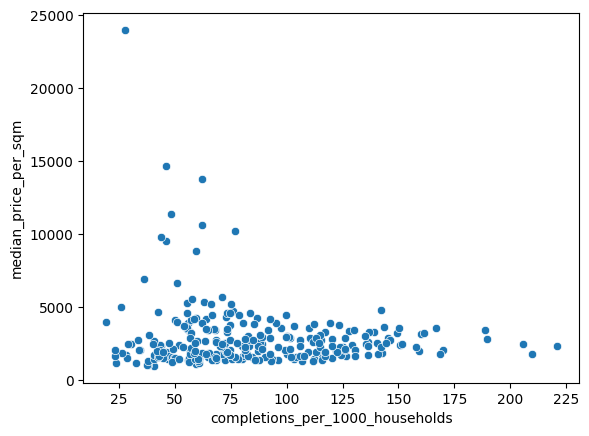

In [168]:
sns.scatterplot(x='completions_per_1000_households', y='median_price_per_sqm', data=processed_df)
plt.show()


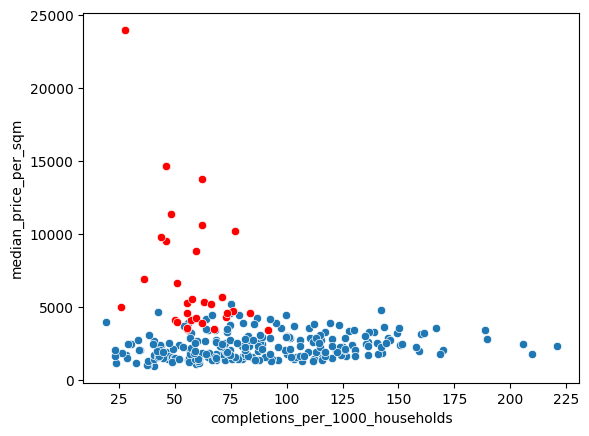

In [195]:
sns.scatterplot(x='completions_per_1000_households', y='median_price_per_sqm', data=processed_df[processed_df[REGION_NAME] != 'London'])
sns.scatterplot(x='completions_per_1000_households', y='median_price_per_sqm', color='red', data=processed_df[processed_df[REGION_NAME] == 'London'])
plt.show()
